In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3,lifelines,rpy2

cs224 
last updated: 2020-03-25 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8
lifelines 0.24.2
rpy2 3.2.6


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 41
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

* [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution)

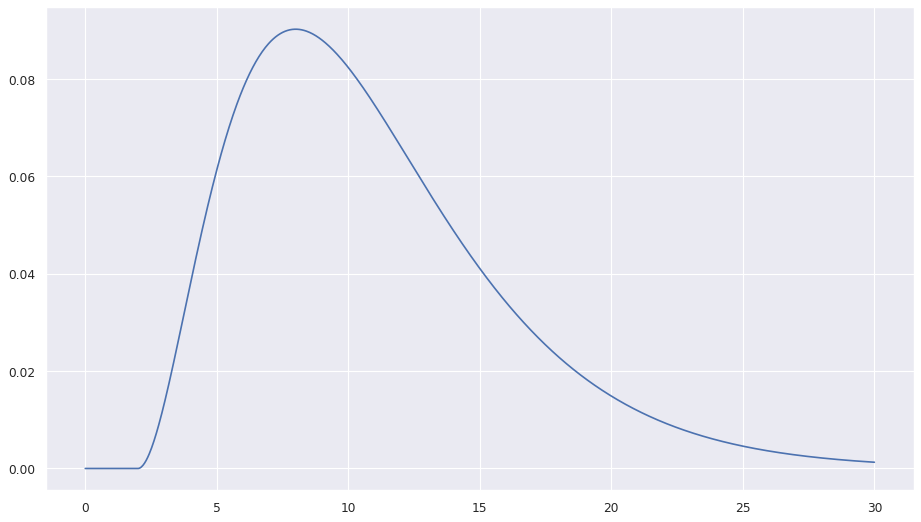

In [5]:
x = np.linspace(0.0,30.0,1000)
gamma_loc   = 2.0
gamma_k     = 3.0
gamme_theta = 3.0
y = stats.gamma(gamma_k, loc=gamma_loc, scale=gamme_theta).pdf(x)
fig=plt.figure(figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
ax.plot(x,y)

In [6]:
china_mortality_analysis = covid19.MortalityAnalysis('China')

In [7]:
china_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-20,81250,0,3253,94,0,4
2020-03-21,81305,0,3259,55,0,6
2020-03-22,81435,0,3274,130,0,15
2020-03-23,81498,0,3274,63,0,0
2020-03-24,81591,0,3281,93,0,7


In [8]:
# china_mortality_analysis.df_lifelines_individual.observed_death.sum()

In [9]:
# china_mortality_analysis.df.head()

In [10]:
# china_mortality_analysis.df.tail()

In [11]:
china_mortality_analysis.fit()

In [12]:
# china_mortality_analysis.wbf.print_summary()

# expected_life_time = china_mortality_analysis.wbf.lambda_ * scipy.special.gamma(1 + 1 / china_mortality_analysis.wbf.rho_)
# expected_life_time/365

In [13]:
china_mortality_analysis.death_rate()

(4.05, 3.92, 4.19)

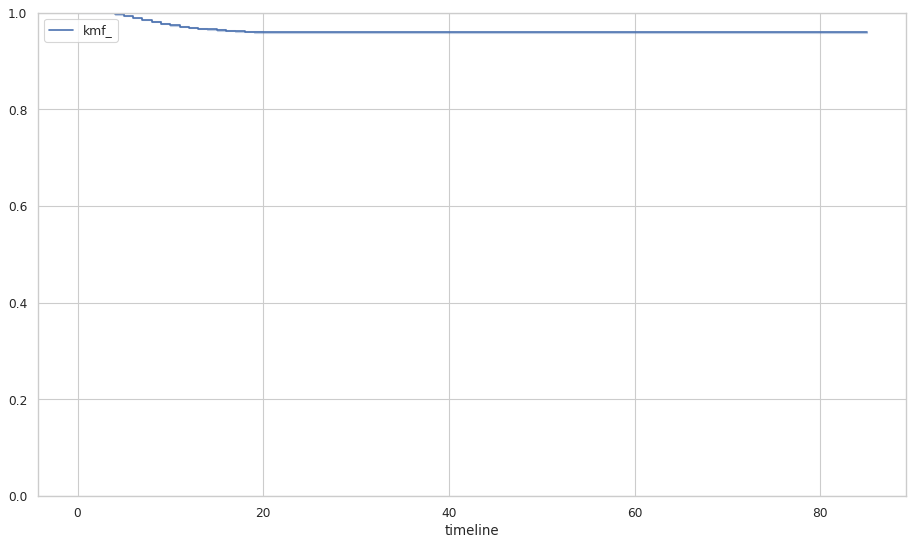

In [14]:
china_mortality_analysis.plot()

(2.02, 1.59, 2.56)


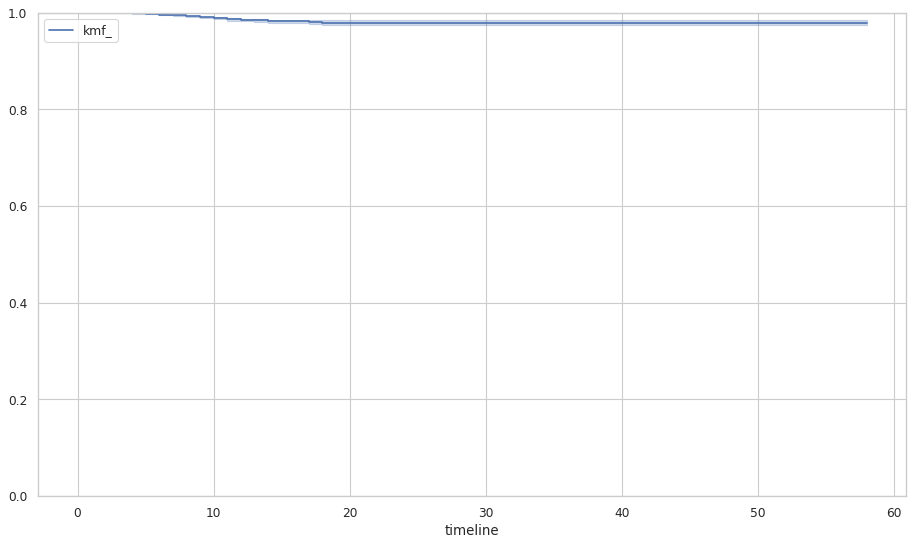

In [15]:
germany_mortality_analysis = covid19.MortalityAnalysis('Germany')
germany_mortality_analysis.fit()
print(germany_mortality_analysis.death_rate())
germany_mortality_analysis.plot()

In [16]:
germany_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-20,19848,180,68,4528,65,24
2020-03-21,22364,239,84,2516,59,16
2020-03-22,24873,266,94,2509,27,10
2020-03-23,29056,453,123,4183,187,29
2020-03-24,32991,3290,159,3935,2837,36


In [17]:
germany_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,666.0,159,507.0,36.0,14,1269.0


(1.54, 1.29, 1.83)
(1.39, 1.16, 1.65)
9937


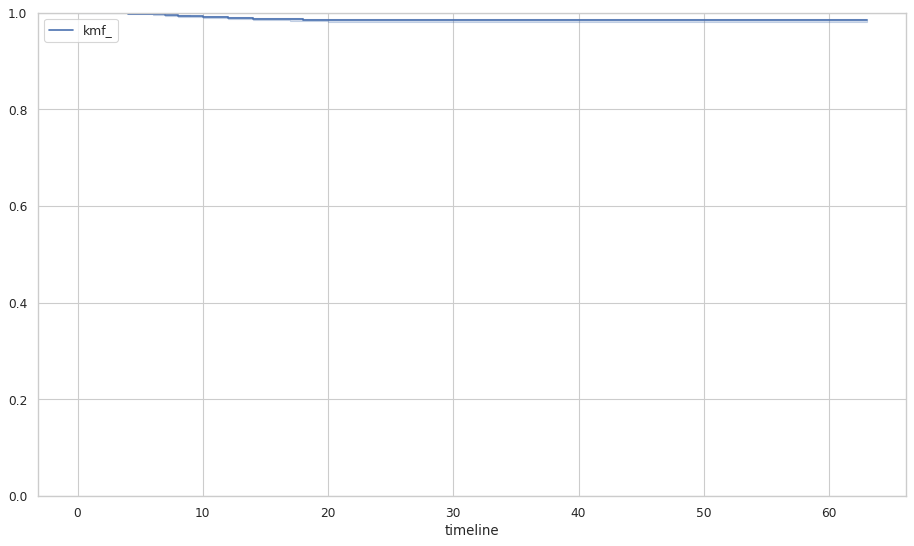

In [18]:
south_korea_name = 'Korea, South'
south_korea_mortality_analysis = covid19.MortalityAnalysis(south_korea_name)
south_korea_mortality_analysis.fit()
south_korea_mortality_analysis2 = covid19.MortalityAnalysis(south_korea_name, first_date=pd.to_datetime('2020-02-20'), init_add=900)
south_korea_mortality_analysis2.fit()
print(south_korea_mortality_analysis.death_rate())
print(south_korea_mortality_analysis2.death_rate())
print(south_korea_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
south_korea_mortality_analysis.plot()

In [19]:
south_korea_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-20,8799,2233,104,147,0,10
2020-03-21,8897,2909,104,98,676,0
2020-03-22,8961,3166,111,64,257,7
2020-03-23,9037,3507,120,76,341,9
2020-03-24,9037,3507,124,0,0,4


In [20]:
# south_korea_mortality_analysis.prepend_df

(16.77, 15.59, 18.04)
(3.91, 3.63, 4.21)
92532


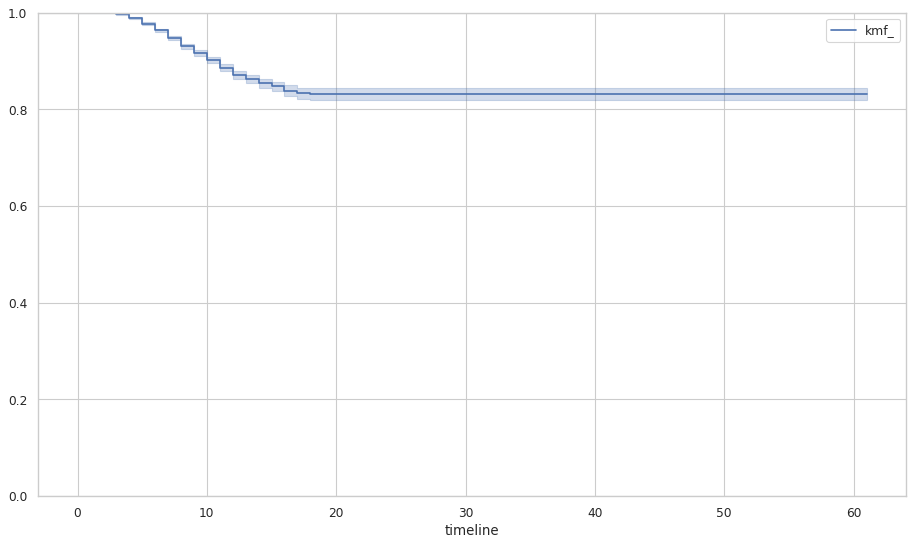

In [21]:
france_mortality_analysis = covid19.MortalityAnalysis('France')
france_mortality_analysis.fit()
france_mortality_analysis2 = covid19.MortalityAnalysis('France', first_date=pd.to_datetime('2020-02-15'), init_add=500, mult=4)
france_mortality_analysis2.fit()
print(france_mortality_analysis.death_rate())
print(france_mortality_analysis2.death_rate())
print(france_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
france_mortality_analysis.plot()

In [22]:
france_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-20,12612,1587,450,1602,1575,78
2020-03-21,14485,1587,562,1873,0,112
2020-03-22,16243,2201,676,1758,614,114
2020-03-23,20123,2207,862,3880,6,186
2020-03-24,22633,3288,1102,2510,1081,240


In [23]:
france_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,3618.0,1102,2516.0,180.0,14,6290.0


(28.15, 26.19, 30.24)
(3.76, 3.56, 3.96)
321435


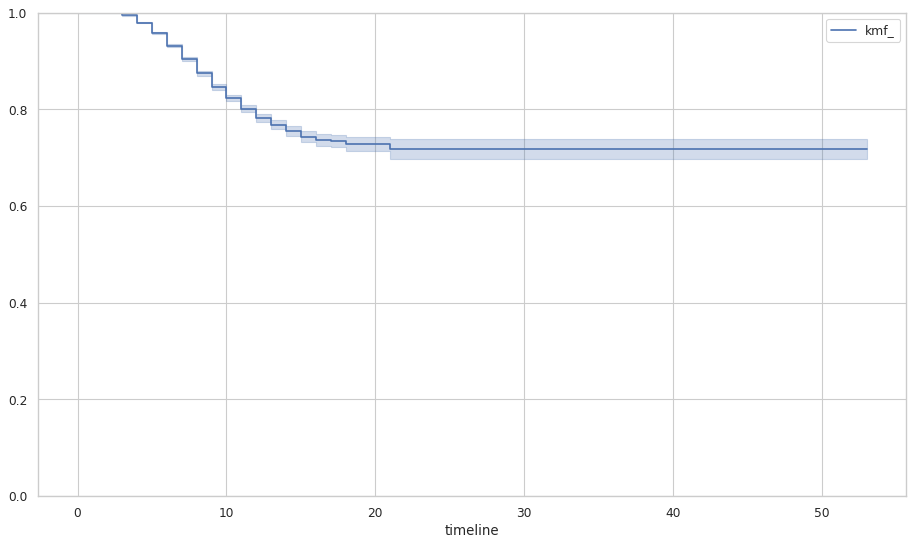

In [24]:
spain_mortality_analysis = covid19.MortalityAnalysis('Spain')
spain_mortality_analysis.fit()
spain_mortality_analysis2 = covid19.MortalityAnalysis('Spain', first_date=pd.to_datetime('2020-03-03'), init_add=800, mult=7.5)
spain_mortality_analysis2.fit()
print(spain_mortality_analysis.death_rate())
print(spain_mortality_analysis2.death_rate())
print(spain_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
spain_mortality_analysis.plot()

In [25]:
spain_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-20,21571,1588,1093,3494,481,260
2020-03-21,25496,2125,1381,3925,537,288
2020-03-22,28768,2575,1772,3272,450,391
2020-03-23,35136,3355,2311,6368,780,539
2020-03-24,42058,3794,2991,6922,439,680


In [26]:
spain_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,12086.0,2991,9095.0,650.0,14,22737.0


(23.56, 20.72, 26.73)
(3.74, 3.35, 4.17)
40338


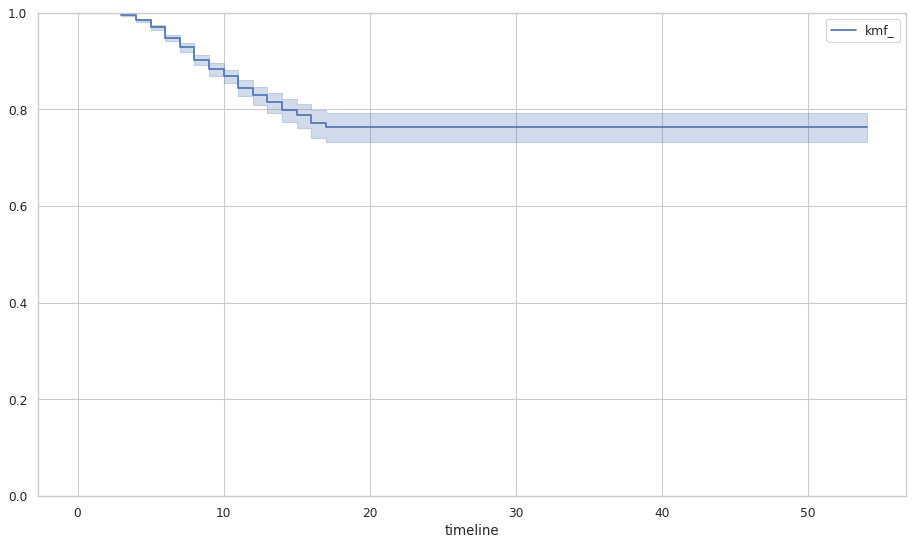

In [27]:
uk_name = 'United Kingdom'
uk_mortality_analysis = covid19.MortalityAnalysis(uk_name)
uk_mortality_analysis.fit()
uk_mortality_analysis2 = covid19.MortalityAnalysis(uk_name, first_date=pd.to_datetime('2020-03-05'), init_add=800, mult=4.5)
uk_mortality_analysis2.fit()
print(uk_mortality_analysis.death_rate())
print(uk_mortality_analysis2.death_rate())
print(uk_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
uk_mortality_analysis.plot()

In [28]:
uk_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-20,4014,67,178,745,0,34
2020-03-21,5067,79,234,1053,12,56
2020-03-22,5745,137,282,678,58,48
2020-03-23,6726,140,336,981,3,54
2020-03-24,8164,140,423,1438,0,87


In [29]:
uk_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,1509.0,423,1086.0,78.0,14,2714.0


In [30]:
# pd.options.mode.chained_assignment = "raise"

(10.0, 9.05, 11.04)
(2.82, 2.52, 3.16)
221964


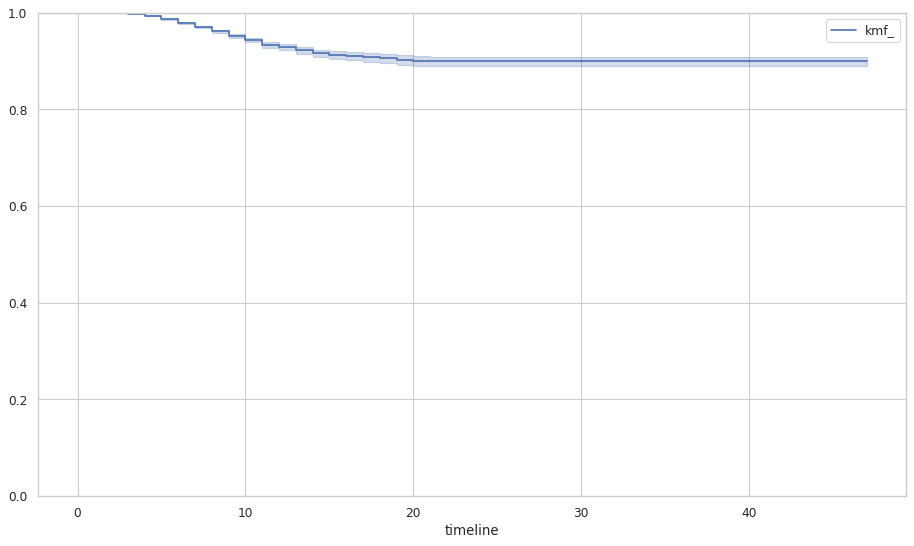

In [31]:
us_mortality_analysis = covid19.MortalityAnalysis('US', first_date=pd.to_datetime('2020-02-29'), init_add=950)
us_mortality_analysis.fit()
us_mortality_analysis2 = covid19.MortalityAnalysis('US', first_date=pd.to_datetime('2020-02-29'), init_add=450, mult=4.0)
us_mortality_analysis2.fit()
print(us_mortality_analysis.death_rate())
print(us_mortality_analysis2.death_rate())
print(us_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
us_mortality_analysis.plot()

In [32]:
us_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-20,19671,147,260,5359,26,52
2020-03-21,26138,176,336,6467,29,76
2020-03-22,35206,176,471,9068,0,135
2020-03-23,46332,176,610,11126,0,139
2020-03-24,55041,348,790,8709,172,180


In [33]:
us_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,6259.0,790,5469.0,391.0,14,13673.0


(25.03, 24.35, 25.71)
(3.42, 3.33, 3.52)
498232


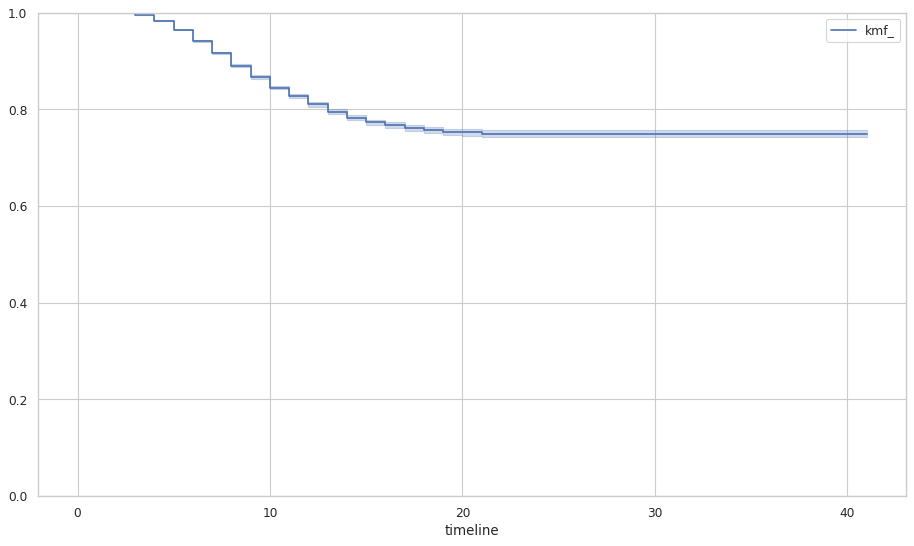

In [34]:
italy_mortality_analysis = covid19.MortalityAnalysis('Italy', first_date=pd.to_datetime('2020-02-21'))
italy_mortality_analysis.fit()
print(italy_mortality_analysis.death_rate())
italy_mortality_analysis2 = covid19.MortalityAnalysis('Italy', first_date=pd.to_datetime('2020-02-21'), init_add=2000, mult=7.0)
italy_mortality_analysis2.fit()
print(italy_mortality_analysis2.death_rate())
print(italy_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
italy_mortality_analysis.plot()

In [35]:
italy_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-20,47021,5129,4032,5986,689,627
2020-03-21,53578,6072,4825,6557,943,793
2020-03-22,59138,7024,5476,5560,952,651
2020-03-23,63927,7432,6077,4789,408,601
2020-03-24,69176,8326,6820,5249,894,743


In [36]:
italy_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,17040.0,6820,10220.0,730.0,14,25549.0


In [37]:
# italy_mortality_analysis2.prepend_df

In [38]:
import rpy2
print(rpy2.__version__)

3.2.6


In [39]:
import rpy2.robjects.packages as rpackages
baseR = rpackages.importr('base')
print(baseR.R_Version().rx('version.string'))

$version.string
[1] "R version 3.6.1 (2019-07-05)"




In [40]:
# from rpy2.rinterface import R_VERSION_BUILD
# print(R_VERSION_BUILD)

In [41]:
import IPython.display
import rpy2, rpy2.robjects, rpy2.robjects.pandas2ri, rpy2.rinterface, rpy2.robjects.packages, rpy2.interactive, rpy2.robjects.lib.ggplot2, rpy2.robjects.lib.grdevices
rpy2.robjects.pandas2ri.activate()

from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')

# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

# R package names
packnames = ('LexisPlotR',)

# R vector of strings
from rpy2.robjects.vectors import StrVector

/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')
/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/lib/ggplot2.py:72: UserWarning: This was designed againt ggplot2 version 3.2.1 but you have 3.3.0
  'have %s' % (TARGET_VERSION, ggplot2.__version__))
/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/vectors.py:927: UserWarning: R object inheriting from "POSIXct" but 

In [42]:
grdevices = rpy2.robjects.packages.importr('grDevices')
# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

lexis = importr('LexisPlotR')
lexis

rpy2.robjects.packages.Package as a <module 'LexisPlotR'>

In [43]:
lexis_grid = rpy2.robjects.r['lexis.grid']
lexis_lifeline = rpy2.robjects.r['lexis.lifeline']

In [44]:
def plot_lexis(mortality_analysis_instance):
    mylexis = lexis_grid(year_start = 2020, year_end = 2021, age_start = 0, age_end = 1) #  lwd = 0.1

    alpha = 1.0
    ix_present = ~mortality_analysis_instance.df_lifelines_individual.observed_death
    ix_lost    = mortality_analysis_instance.df_lifelines_individual.observed_death
    mylexis = lexis_lifeline(lg = mylexis , entry = mortality_analysis_instance.df_lifelines_individual['start_date'][ix_present], exit = mortality_analysis_instance.df_lifelines_individual['end_date'][ix_present], colour = "orange", alpha = alpha, lwd = 0.4)
    mylexis = lexis_lifeline(lg = mylexis , entry = mortality_analysis_instance.df_lifelines_individual['start_date'][ix_lost]   , exit = mortality_analysis_instance.df_lifelines_individual['end_date'][ix_lost]   , colour = "blue"  , alpha = alpha, lwd = 0.4, lineends = True)

    with rpy2.robjects.lib.grdevices.render_to_bytesio(grdevices.png, width=1.5*1024, height=1.5*896, res=90) as img:
        rpy2.robjects.r.print(mylexis)   
    IPython.display.display(IPython.display.Image(data=img.getvalue(), format='png', embed=True))

In [45]:
# plot_lexis(italy_mortality_analysis)

In [46]:
# plot_lexis(italy_mortality_analysis2)

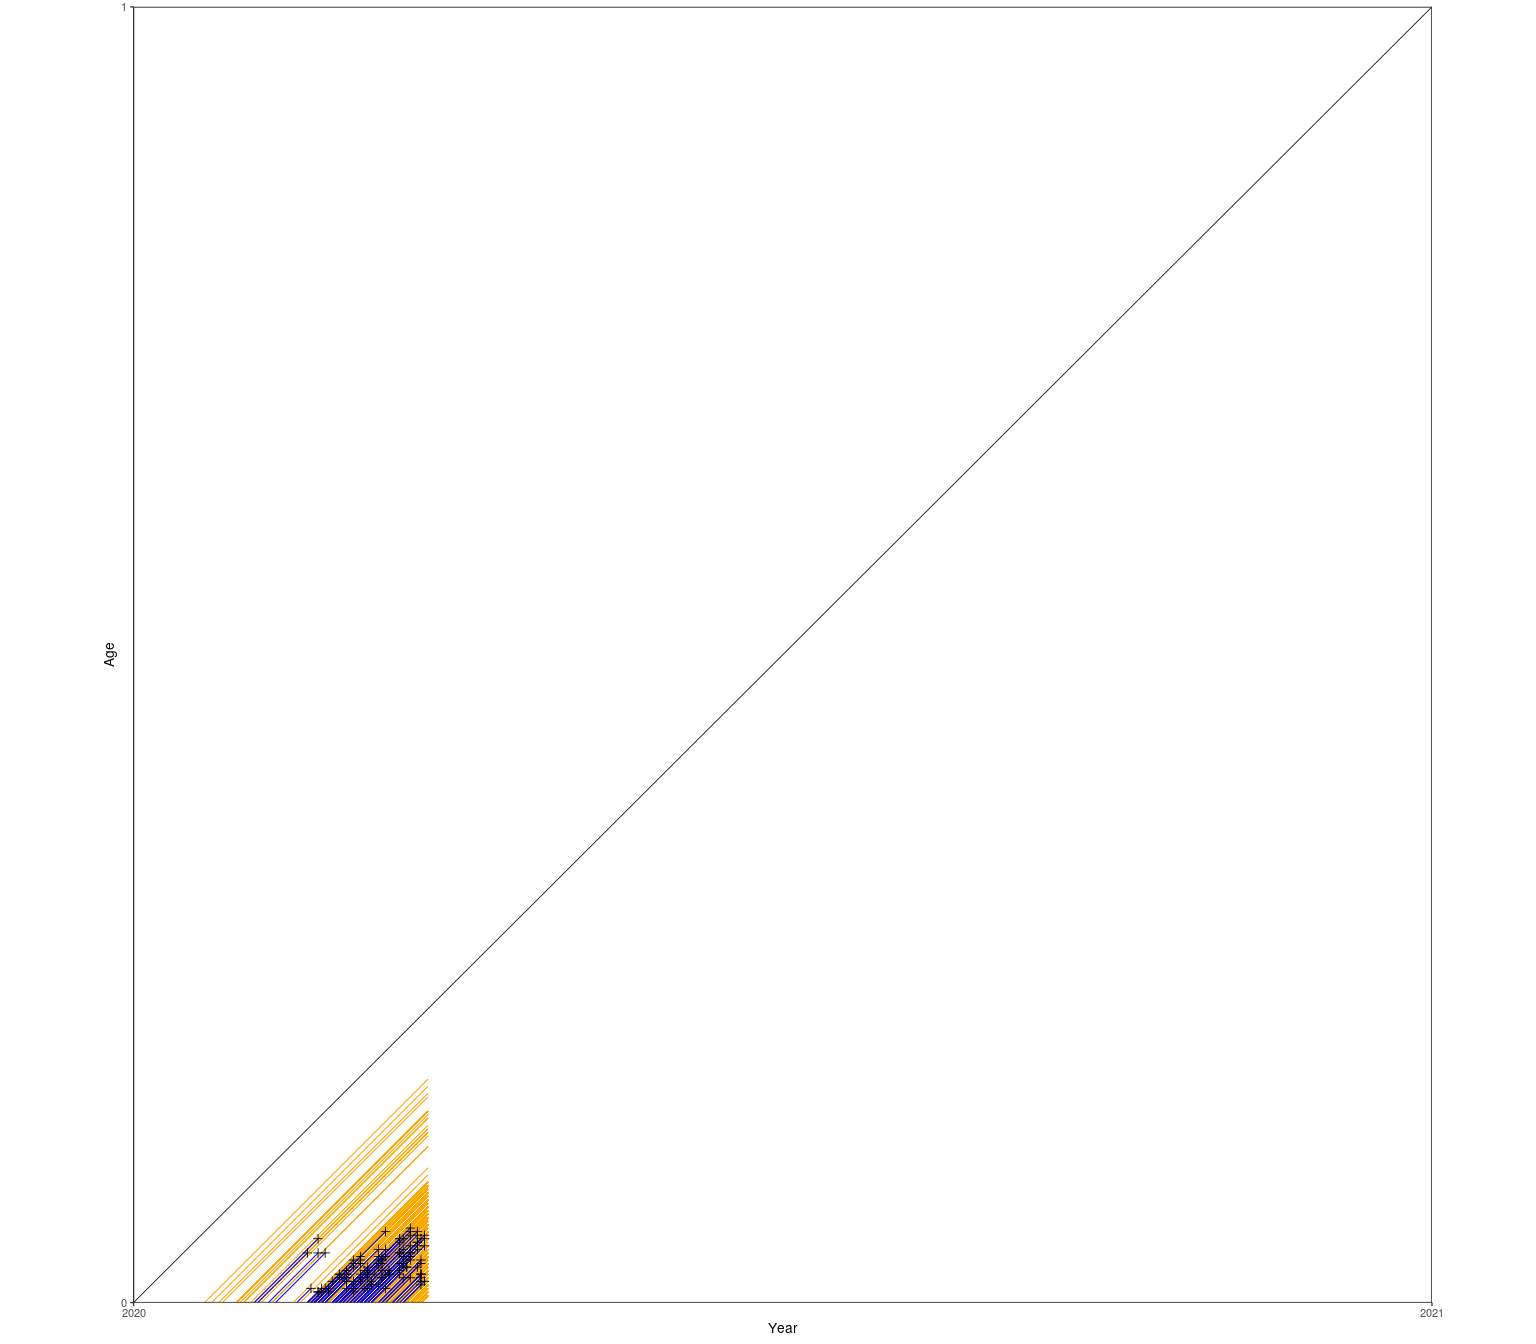

In [47]:
plot_lexis(south_korea_mortality_analysis)